# デュアル構造を持つネットワークの検索用ノートブック(2019/11/26作成)

- リファクタリングを兼ねてもう一度綺麗に実装してみる

## 初期設定とライブラリのimport

In [1]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os

In [2]:
BASE_PATH = './dataset/T_Shirt_all/'
model = 'improvedTripletLoss'
model = 'TripletLoss'

## エラー対応
- ~~**RTX系のGPU**で回すとUnknownErrorを吐くため以下コードにより回避~~
- なぜかこちらのコードがエラーを吐くようになった(GPUマシンのアップデート後)
- GPU番号を指定していないことが原因らしい

In [3]:
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.keras.backend.set_session(tf.Session(config=config))

- GPUを指定する

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="0", # specify GPU number
        allow_growth=True
    )
)
set_session(tf.Session(config=config))

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## モデルの読み込み

In [5]:
from keras.models import load_model

In [7]:
vec_length = 300
model_epoch = 99
ALPHA = 1.0
BETA = 0.05 #improved triplet lossの場合

In [8]:
# model_dir = "./model/T_Shirt/improved_tripletloss/a{}b{}".format(ALPHA,BETA)
model_dir = "./model/T_Shirt/improvedEditFiler/a{}b{}".format(ALPHA,BETA)

In [9]:
con_embNet = load_model(model_dir+'/{}/con_e{}.h5'.format(vec_length,model_epoch), compile=False)
shop_embNet = load_model(model_dir+'/{}/shop_e{}.h5'.format(vec_length,model_epoch), compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# con_embNet = load_model('./model/T_Shirt/tripletloss/a0.1/512/con_e99.h5', compile=False)
# shop_embNet = load_model('./model/T_Shirt/tripletloss/a0.1/512/shop_e99.h5', compile=False)

## Testデータの読み込み
- 学習前にtrain/test分割してpickle保存したファイルからtestに用いる商品idをロードする
- 一つの商品idに対して一つの[Street画像,Shop画像]ペアとする。詳しくは`./datagen.py`参照

In [11]:
f = open("./pickle/test_ids.pickle","rb")
test_ids = pickle.load(f) #test用の商品id

- 自作モジュールのインポート

In [12]:
from modules import datagen

In [13]:
test_pairs = datagen.get_test_pairs(test_ids,BASE_PATH,seed_num=0)

100%|██████████| 2032/2032 [00:02<00:00, 784.17it/s]


- 中身は`[商品id,[Street画像のパス,Shop画像のパス]]`

In [14]:
test_pairs[0]

[10696,
 ['./dataset/T_Shirt_all/id_00010696/comsumer_01.jpg',
  './dataset/T_Shirt_all/id_00010696/shop_01.jpg']]

- 作成したtest_pairsをpickleで保存する

In [15]:
f = open('./pickle/test_pairs.pickle', 'wb')
pickle.dump(test_pairs, f)

## 検索対象の画像群(gallery)の作成

- galleryリストに対して、test_pairsから[商品id, Shop画像パス]のリスト作成してappendする

In [16]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])

In [17]:
print(gallery[0])
print('gallery length = {}'.format(len(gallery)))

[10696, './dataset/T_Shirt_all/id_00010696/shop_01.jpg']
gallery length = 2032


## galleryを特徴空間ベクトルに埋め込む

- 埋め込み次元はvec_lengthとして定義済み
- 最初に次元数分のnumpy配列を用意しておき、書き換える。
- ans_idsは正解となる商品idのリスト(test_pairsをforで回してtp[0]のリストを作るのと同義)

In [18]:
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
print(emb_vecs.shape)
print(ans_ids.shape)

(2032, 300)
(2032,)


- shop_embNet.predict()で推論を行う。デュアル構造のため、入力として同じimgを二つ与える
- 入力時の形を合わせるためexpand_dimsの処理が必要(試行錯誤の結果なので詳細は忘れた)

In [19]:
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
    emb_vecs[i] = shop_embNet.predict([np.expand_dims(img,axis=0),np.expand_dims(img,axis=0)])[0] # need [0] because of expanding dimension -> [[]]

100%|██████████| 2032/2032 [00:18<00:00, 107.09it/s]


- **重要!!** 後に結果を解釈するために埋め込んだベクトルをpickleに保存

In [20]:
f = open(model_dir+'/{}/gallery{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(emb_vecs,f)

In [21]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/gallery{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(emb_vecs,f)

- ユークリッド距離計算用関数

In [22]:
def euclid_dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

- Queryの用意

In [23]:
query_ids = np.zeros(len(test_pairs))
print(query_ids.shape)

(2032,)


In [24]:
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
query_ids[:5]

array([10696., 23825., 17789., 22720.,  3304.])

## 距離計算とランキングの算出
- topN_id_listはそれぞれのqueryに対し上位N個までの商品idのランキングがリストとして算出される。
- [[商品Aのランキング],[商品Bのランキング],...[商品Xのランキング],...]のような形

In [25]:
N = 50

- Street画像(Query)の**埋め込みと距離計算**
- argsort()は昇順に並べたときのindexの配列を返す
- similaritiesとans_idsの同じインデックスは同じ商品idを指している
- つまり、対応するans_idsをidxsリストを与えることで切り出す

In [26]:
topN_id_list = []
query_emb_vecs = np.zeros((len(gallery),vec_length))
for i,tp in enumerate(tqdm(test_pairs)):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    query_emb = con_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0),np.expand_dims(img.astype(np.float32),axis=0)])[0]
    query_emb_vecs[i] = query_emb
    # calculation
    similarities = np.zeros(len(gallery))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = euclid_dist(query_emb,emb_vec)
    # argsort
    idxs = similarities.argsort()
    topN_id_list.append(ans_ids[idxs[:N]])  

100%|██████████| 2032/2032 [00:46<00:00, 43.59it/s]


In [37]:
topN_id_list[0]

array([ 3479., 28251.,  7805., 19365.,   769., 28617.,  9898., 20831.,
       27799., 11298., 17408., 15509., 31993.,  7312., 30237., 14612.,
       15761.,  2362., 21252., 20133., 23988., 32780., 33876., 18846.,
        9403., 25930., 15541., 26391., 28985.,  7607., 29771.,  7942.,
        7617., 16073., 16004., 14066.,  5060., 21419., 16707., 24677.,
       13970., 18474., 19255., 17172., 13567., 19352.,  4559., 33396.,
       19392., 14268.])

- 検索結果画像を表示するためにtopN_id_listを保存

In [28]:
f = open(model_dir+'/{}/topN_id_list{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(topN_id_list,f)

In [29]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/topN_id_list{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(topN_id_list,f)

In [30]:
len(emb_vecs)

2032

- **重要!!** のちに結果を解釈(**ヒストグラム描画**など)するためquery_embをpickle保存

In [33]:
f = open(model_dir+'/{}/query{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(query_emb_vecs,f)

In [34]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/query{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(query_emb_vecs,f)

## Top-Kの計算とグラフの描画

- ans_idsとtopN_id_listをzipで同時に回す
- あるans_idを見たとき、対応するインデックスのtopN_idの中に同じidが入っていればcntを+1

In [35]:
def calc_topk_vals(k_values,ans_ids,topN_id_list):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/len(ans_ids))
    return topk_vals

In [36]:
x = list(range(1,51))
topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)

In [37]:
f = open(model_dir+'/{}/topK_vals.txt'.format(vec_length), 'wb')
pickle.dump(topk_vals, f)

In [38]:
# f = open('./model/T_Shirt/topK/TripletLoss_{}.txt'.format(vec_length), 'wb')
# pickle.dump(topk_vals, f)

In [39]:
topk_vals

[0.0024606299212598425,
 0.004921259842519685,
 0.005905511811023622,
 0.008366141732283465,
 0.009350393700787402,
 0.011811023622047244,
 0.013779527559055118,
 0.015748031496062992,
 0.0172244094488189,
 0.018700787401574805,
 0.02066929133858268,
 0.021653543307086614,
 0.02312992125984252,
 0.025590551181102362,
 0.028543307086614175,
 0.029035433070866142,
 0.030019685039370077,
 0.031496062992125984,
 0.0344488188976378,
 0.03543307086614173,
 0.03740157480314961,
 0.03887795275590551,
 0.040354330708661415,
 0.04084645669291338,
 0.04232283464566929,
 0.043799212598425195,
 0.04576771653543307,
 0.04675196850393701,
 0.04675196850393701,
 0.04921259842519685,
 0.05019685039370079,
 0.050688976377952756,
 0.05216535433070866,
 0.05265748031496063,
 0.0531496062992126,
 0.054133858267716536,
 0.054625984251968504,
 0.05561023622047244,
 0.05708661417322835,
 0.05954724409448819,
 0.0610236220472441,
 0.06348425196850394,
 0.06791338582677166,
 0.06988188976377953,
 0.070866141732

- グラフの描画

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


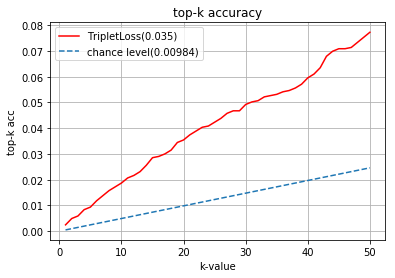

In [40]:
x = list(range(1,51))
chancelv=np.array(x)/len(test_pairs)

topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)
plt.plot(x,topk_vals,c='r',label='TripletLoss({})'.format(round(topk_vals[19],3)))
# plt.plot(x,topk_vals,c='r',marker='o',label='improvedTripletLoss({})'.format(round(topk_vals[4],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level(0.00984)')

# graph settings
plt.legend(loc='best')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")
plt.show()

# 結果と考察

- vec_lengthは結果に対してかなり影響がある

Top20 accuracy

| Dimension | Single | Dual(Triplet Loss) | Dual(improved Triplet Loss) |
|:-:|:-:|:-:|:-:|
|100|  0.141  | - | -|
|200|-  |0.175  | - |
|300|-  | 0.126 | 0.201 |
|512|0.2  |0.156  |0.108  |

alpha=0.5にしたら0.157に変化した
原因はhistgram要確認
